In [2]:
from util_nn import *

import matplotlib 
import matplotlib.pyplot as plt
#%matplotlib inline
import IPython.display as ipd
import copy
import util_midi
import mir_eval
from util_midi import *
%matplotlib inline

def rmsq(X):
    return np.sqrt((X**2).mean())
def norm_by_freq(mroll):
    #### This may be improved
    wt = (np.linspace(0,1,mroll.shape[1])).T
#         sqwt = wt**2
#         sq_mroll = mroll **2
#         SUM = (sq_mroll*sqwt).sum(axis = 1,keepdims = 1)
    mroll = mroll*wt
    SUM = mroll.sum(axis = 1,keepdims = 1)
#         SUM = (mroll*wt).sum(axis = 1,keepdims = 1)
    SUM[SUM==0]=1
    mroll = mroll/SUM.astype('float32')
    return mroll

def mroll2chroma(mroll,norm = 1):
#     if chroma:
    if mroll.shape[-1]==12:
        return mroll
    mroll = mroll[:,:120]
    SP = list(mroll.shape)
#         SP[1] = 12; SP.append(-1)
#         mroll = np.reshape(mroll,SP).sum(axis = 2)
    SP[1] = -1; SP.append(12)
#     cmroll = np.clip(cmroll,0,1)
    #     cmroll = 
    if norm:
        mroll = norm_by_freq(mroll)
        

#         SUM = cmroll.sum(axis = 1,keepdims =1 )
#         SUM[SUM==0]=1
#         cmroll = cmroll / SUM.astype(float)
#     cmroll = (np.reshape(mroll,SP).sum(axis = 1) > 0).astype('float')
    cmroll = (np.reshape(mroll,SP).sum(axis = 1)).astype('float')
#         cmroll = np.clip(cmroll,0,1)
    return cmroll 
#     print mroll.shape

    
def midi_roll_play(mroll,chroma = False):
    if mroll.shape[-1]==12:
        freqs = mir_eval.transcription.util.midi_to_hz(np.arange(60,72))
    else:
        freqs = mir_eval.transcription.util.midi_to_hz(np.arange(0,128))
#     mroll = np.log(mroll+1E-5)
    SHAPE = mroll.shape
    mroll = mroll.T
#     mroll = mroll * freqs.T[:,None]
#     mroll = norm_by_freq(mroll)
    Xs_exp = mir_eval.sonify.time_frequency( mroll ,freqs,times = 1./20*np.arange(SHAPE[0]),fs = 16000)
#     Xs_exp = np.hstack([Xs_exp,[0]*(len(cpXs)-len(Xs_exp))])
    return Xs_exp/np.sqrt((Xs_exp**2).mean())


def compare(log = 1, mode = 'test',best_agent = None,chroma = False,overlap = 1):
    FSIZE = [12,4]
    if best_agent is None:
        best_agent = copy.copy(agent)
        best_agent.load()
    plt.figure(figsize = FSIZE)

    if mode == 'test':
        pXs = data[0]["X"][:100]
        pYs_exp = data[0]["Y"][:100]
    else:
        pXs = Xs[:100]
        pYs_exp = Ys[:100]
#     assert not (pXs[0] - Xs[0]).any()
#     pXs = Xs[:500]
#     pYs_exp = Ys[:500]
    pYs_act = best_agent.model.predict_on_batch(pXs) 
    pYs_act += 1E-5
#     compare(log = 1)
    if chroma:
        if pYs_exp.shape[-1]==128:
            pYs_exp = mroll2chroma(pYs_exp,norm = 1)
        if pYs_act.shape[-1]==128:
            pYs_act = mroll2chroma(pYs_act,norm = 1)
    plt.pcolormesh(pYs_exp.T,alpha = 0.75)
    if overlap:
        pass
    else:
        plt.figure(figsize = FSIZE)
        
    Z1 = pYs_act.T
    if log:
        plt.pcolormesh(Z1,
                       alpha = 0.5,
                  norm=matplotlib.colors.LogNorm(vmin=Z1.min(), vmax=Z1.max())
                  )
    else:
        plt.pcolormesh(Z1)
#     if overlap:
#         pass
#     else:
    if 1:
        plt.figure(figsize = FSIZE)
    plt.pcolormesh((pYs_act - pYs_exp).T )
        
    if chroma:
        YLIM = [0,12]
    else:
        YLIM = [40,90]
    plt.gca().set_ylim(YLIM)
#     plt.gca().set_xlim(0,200)
#     plt.gca().set_ylim(YLIM)
#     plt.figure()
    
    ipd.display(ipd.Audio(midi_roll_play(pYs_act),rate = 16000))
    ipd.display(ipd.Audio(midi_roll_play(pYs_exp),rate = 16000))
    cpXs = np.concatenate(pXs,axis = 0)
    ipd.display(ipd.Audio(cpXs,rate = 16000))

    
# ali = 'test'
# alias = 't4'
def pretrain(agent = None, batchsize = 30000,nepc = 10):
    IniEPOCH=0
    if agent is None:
        agent = PGAgent(16000/20, 128,model = make_model())

    # data = load_data()
    # Xs,Ys = make_buffer(data[1:])
    if batchsize== -1:
        batchsize = len(Xs)
    idx = np.random.choice(len(Xs),batchsize,replace=0)
    subXs = Xs[idx]
    subYs = Ys[idx]

#     opt_par.update({'loss':LOSS})
    opt = keras.optimizers.sgd(**opt_par)
    try:
    #     agent.load()
        pass
    except Exception as e:
        print e
    # opt_par = {}
    # opt = keras.optimizers.Adam(**opt_par)
    # agent.name = "adam_%s"%opt_par_flat

    opt_par_flat = '-'.join(['_'.join(str(y) for y in x) for x in opt_par.items()]).replace('.','Dot')
    agent.name = "sgd_%s_%s"% (alias,flatten_param(opt_par))



    agent.model.compile(loss=LOSS, optimizer=opt
                         ,metrics=['accuracy'])

#     nepc = 10
    r = agent.model.fit(subXs, subYs, epochs= IniEPOCH + nepc, initial_epoch=IniEPOCH, batch_size=512, validation_split=0.2,shuffle = 1, verbose = 1,
                         callbacks=default_callbacks(agent))
    IniEPOCH += nepc
    plot_model_loss(r)
    return agent,r
# agent = pretrain()
# compare(log = 1, mode = 'test',chroma = 1)
# compare(log = 1, mode = 'test',chroma = 0)

# pXs = data[0]["X"][:100]
# pYs_exp = data[0]["Y"][:100]
# ipd.display(ipd.Audio(midi_roll_play(pYs_exp,chroma = 1),rate = 16000))

import sys
# class ClearlineCallback(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         sys.stdout.write("\033[F")
#         sys.stdout.write("\033[F")
#         print "\r\r"
class NewlineCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print
    def on_epoch_end(self, epoch, logs={}):
        print
        pass
#         print "\n"
import keras


def default_callbacks(self):
    ck_all = self.callback_checkpoint(0)
    ck_best = self.callback_checkpoint(1)
    callbacks = [
#         ClearlineCallback(),
#         keras.callbacks.ProgbarLogger(),
                 NewlineCallback(),
                 ck_all,
                 ck_best,
#                  NewlineCallback()
                ]
    return callbacks

# def abs_KL_div(y_true, y_pred):
#     y_true = K.clip(y_true, K.epsilon(), 1)
#     y_pred = K.clip(y_pred, K.epsilon(), 1)
#     return K.sum(y_true * K.abs(K.log(y_true / y_pred)), axis=-1)

In [4]:
opt_par = {'lr': 0.01, 'momentum': 0.75,'decay':0.000}

# LOSS = 'kullback_leibler_divergence'
# LOSS = 'mean_absolute_percentage_error'
# LOSS = 'hinge'
# LOSS = 'categorical_crossentropy'
# LOSS = 'binary_crossentropy'
alias = 't22'
ACT_FUNC = "relu"
# # ACT_FUNC = "selu"
# tf.device('/cpu:0')
# LOSS = 'sparse_categorical_crossentropy'
LOSS = 'binary_crossentropy'
from keras.models import Model

# Ns = [2,3,4,5,6][::-1]
Nl = 11
# Ns = [30]*Nl
Ns = 4 * np.clip(np.arange(1, Nl+1),None,15)
# Ss = [2,4,8,16,16,16,16,16,100,100,100]
Ss = 2 * np.clip(np.arange(1, Nl+1),None,5)
# Ss = [7] * Nl
# Ss = [2,4,8,16,32,64,128,256]
Ws = 2 * np.clip(np.arange(1, Nl+1),None,5)
# Ws = [7] * Nl
# Ws = [2] * Nl
# Ss = [2,2,2,3,4][::-1]
# Ns = [20,20,20]
# Ss = [16,16,16]
# LOSS = 'binary_crossentropy'
LOSS = abs_KL_div
# LOSS = 'kullback_leibler_divergence'

def make_model(self = None):
    
    model = Sequential()
#         model = Sequential_wrapper()
#         model.add(Reshape((80, 80, 1), input_shape=(self.state_size,)))
    
#     model.add(Reshape((self.state_size,1), input_shape=(self.state_size,)))
    input_size = 800; output_size = 128
    model.add(Reshape((input_size,1,1), input_shape=(input_size,)))

#     S = 85;niter = 1
    S = 9;niter = 2
#     S = 4;niter = 3    
    niter = 4
    n = S
    nextlayer = lambda x:(    x//n - 1)
    
    N0 = 64
    S2 = 30
    N2 = 10
    Lx = 800
    
#         if i == 0:

#     #         N = 1 if i==0 else N0
#             N = N0
#             if i==0:
#                 N2_curr = 1
#             else:
#                 N2_curr = N2
    N2_curr = 1
    N = 10
    # Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
    # Note that we can name any layer by passing it a "name" argument.
    main_input = Input(shape=(800,), 
#                        dtype='int32', name='main_input'
                      )
    curr = Reshape((input_size,1,1), input_shape=(input_size,))(main_input)

    imax = len(Ns)
    for i in range(imax):
#     for i in range(int(np.log(800)/np.log(S))-1):
        N = Ns[i];S = Ss[i];W = Ws[i]
#         print curr.get_shape()
#         print type(curr._keras_shape[2])
#         print keras.backend.shape(curr)
        curr = Conv2D( N, ( W, 1),
#         curr = Conv2D( N, ( S*8, int(curr._keras_shape[2])),
#         curr = Conv2D( N, ( S*8, curr._keras_shape[2]//2),
                  dilation_rate = (S,1),
#                    strides=(S, 1),
                                     border_mode='valid',
#                              border_mode='dilated',
                                    activation=ACT_FUNC, init='he_uniform')(curr)
#         print curr._keras_shape
#         curr = Reshape((int(curr._keras_shape[1]),1,-1))(curr)
#         curr = Dense(int(curr.get_shape()[-1]))(curr)
        if i+1==imax:
#             curr = Dense(12)(curr)
            pass
#         curr = Permute((1,3,2))(curr)
    
#         conv=conv_layer(curr,(800//S + 800//(S+1))//2)
#         conv=conv_layer(curr,S)
#         clayer.append(
#     curr = Flatten()(curr)
    concat = curr
#     main_output = Dense(128,activation='softmax')(Flatten()(concat))
#     main_output = Dense(12,activation='softmax')(Flatten()(concat))
#     main_output = Dense(128,activation='sigmoid')(Flatten()(concat))
    main_output = Dense(128,activation='softmax')(Flatten()(concat))
#     main_output = Dense(12,activation='softmax')(Flatten()(concat))
    model = Model(inputs=[main_input], outputs=[main_output])

    opt = Adam()
    model.compile(loss=LOSS, optimizer=opt
                 ,metrics=['accuracy'])
    return model
# make_model()

agent = PGAgent(16000/20, 128,model = make_model())
# agent.load()
agent.summary()
IniEPOCH = 0

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (2, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(2, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (4, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(4, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (6, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(6, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(8, 1))`
/home/shou

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 800)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 800, 1, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 798, 1, 4)         12        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 786, 1, 8)         136       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 756, 1, 12)        588       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 700, 1, 16)        1552      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 610, 1, 20)        3220      
__________

In [9]:
!ls Models/sgd_{alias}* -tl

-rw-rw-r-- 1 shouldsee shouldsee  647784 Dec 12 12:45 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.40.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647784 Dec 12 12:45 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.40.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647784 Dec 12 12:44 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.31.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647784 Dec 12 12:44 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.30.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647816 Dec 12 12:00 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.37.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647816 Dec 12 10:57 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.37.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647816 Dec 12 10:55 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.36.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647776 Dec 12 10:18 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-10-0.37.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647776

In [396]:
# !mkdir -p Models/archive
fname = !ls Models/sgd_{alias}* -t | head -1
!cp {fname[0]} Models/archive
!ls Models/archive
# !ls Models/sgd_{alias}* -t

sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.24.hdf5
sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.41.hdf5


In [22]:
fname = !ls Models/sgd_{alias}* -t | head -1
fname = fname[0]
print fname
!cp {fname} Models/archive
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-20-0.64.hdf5'
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.41.hdf5'
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.34.hdf5'
# agent.load(fname)

# agent.summary()

Models/sgd_t22_lr_0Dot01-momentum_0Dot75-decay_0Dot0-05-0.36.hdf5


In [5]:
fname = !ls Models/sgd_{alias}* -t | head -1
fname = fname[0]
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-20-0.64.hdf5'
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.41.hdf5'
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.34.hdf5'
agent.load(fname)

# agent.summary()

In [3]:
agent.load()

In [105]:
agent.model.loss

<function util_nn.abs_KL_div>

In [29]:
agent = PGAgent(16000/20, 128,model = make_model());

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (2, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(2, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (4, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(4, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (6, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(6, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:87: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", dilation_rate=(8, 1))`
/home/shou

In [101]:
# !ls sample/MIDI/midiworld/ -lt

In [6]:
# Ys.shape 
_ = Ys * np.arange(Ys.shape[1])[None,:]
_.shape

(88602, 128)

In [23]:
# np.random.seed(0)
# agent,r = pretrain()

def check_readable(DIR):
    FILES0 = list(os.walk(DIR))[0][-1]
    FILES0 = [os.path.join(DIR,f) for f in FILES0]
    for f in FILES0:
        try:
            _ = np.load(f)
        except:
            print f
            os.remove(f)


DIRs = [
#         'sample/MIDI/',
#         'sample/MIDI/midiworld/',
#         'sample/MIDI/jsbach.aug',
        'sample/MIDI/jsbach',
#     'sample/MIDI/artificial/',
       ]
DATA = []
for DIR in DIRs:
    data = load_data(DIR)
    Xs,Ys= make_buffer(data[1:],truncate = 0)
#     scale = np.sqrt((Xs**2).mean())/100
#     noise = np.random.normal(scale = scale, size = Xs.shape)    
#     Xs = Xs + noise
    fs = np.arange(1,Ys.shape[1]+1)[None,:]
#     YS = Ys * np.exp(-fs)
#     Ys = np.exp(Ys)
#     Ys = Ys
#     Ys = Ys.sum()
#     Ys = norm_by_freq(Ys)
#     Ys = Ys 
#     Ys = mroll2chroma(Ys,norm = 0)
    DATA.append([Xs,Ys])
import itertools
cDATA = [np.concatenate(lst,axis = 0) for lst in itertools.izip(*DATA)]    

In [494]:

# for f in 
# !rm 'sample/MIDI/midiworld/620.both.npy'
# !rm 'sample/MIDI/jsbach.aug/bwv582P-4S60.both.npy'
# !rm 'sample/MIDI/jsbach.aug/bwv552pP2S0.both.npy'
# !rm 'sample/MIDI/jsbach.aug/bwv552pP4S0.both.npy
# !find {DIR} -size -5000

sample/MIDI/jsbach.aug/jsbwv552P1S60.both.npy


In [29]:
!mkdir -p sample/MDIDI/jsbach.aug/archive
!ls sample/MDIDI/jsbach.aug/archive
!ls sample/MIDI/jsbach.aug/*.both.npy -1 -f | head -n 200 | xargs mv -t sample/MIDI/jsbach.aug/archive

ls: write error: Broken pipe
mv: failed to access 'sample/MIDI/jsbach.aug/archive': No such file or directory


In [459]:
!ls sample/MIDI/jsbach/*.both.npy -1 | wc -l

456


In [454]:
!ls sample/MIDI/jsbach/*.mroll.npy -1 | wc -l

454


In [447]:
!ls sample/MIDI/jsbach/*.single_mid -1 | wc -l

576


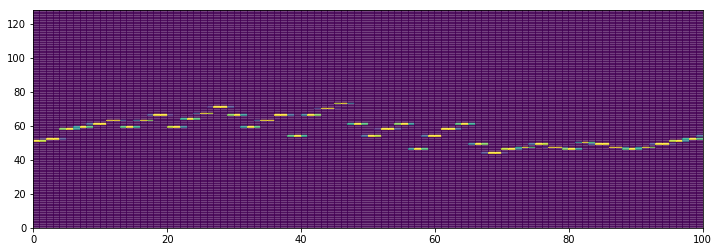

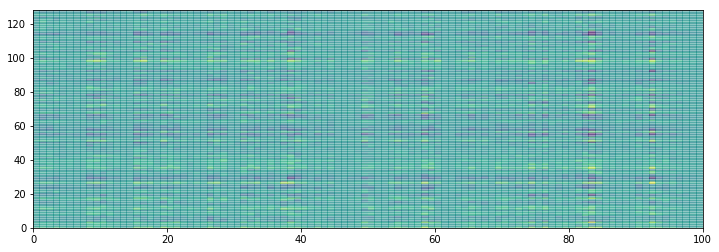

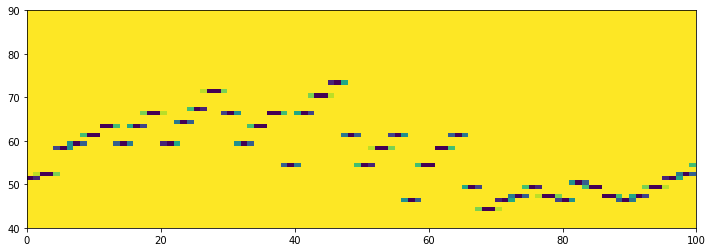

Train on 40000 samples, validate on 10000 samples

Epoch 1/5
39936/40000 [============================>.] - ETA: 0s - loss: 15.5718 - acc: 0.0337
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.02930, saving model to Models/sgd_t22_lr_0Dot01-momentum_0Dot05-decay_0Dot0-01-0.03.hdf5
40000/40000 [==============================] - 12s 296us/step - loss: 15.5705 - acc: 0.0336 - val_loss: 14.9497 - val_acc: 0.0293

Epoch 2/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.8536 - acc: 0.0301
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc did not improve
40000/40000 [==============================] - 10s 246us/step - loss: 14.8539 - acc: 0.0301 - val_loss: 14.9377 - val_acc: 0.0204

Epoch 3/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.8476 - acc: 0.0310
Epoch 00003: saving model to Models/tst-best_only.hdf5
Epoch 00003: val_acc improved from 0.02930 to 0.03880, saving mode

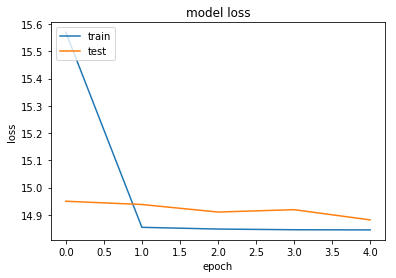

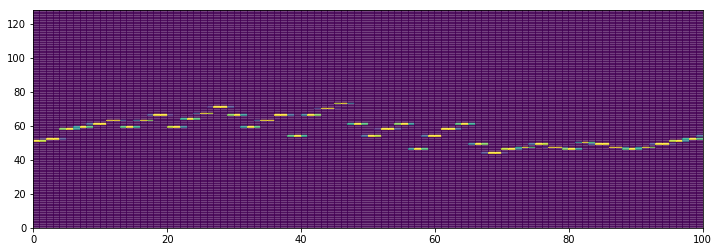

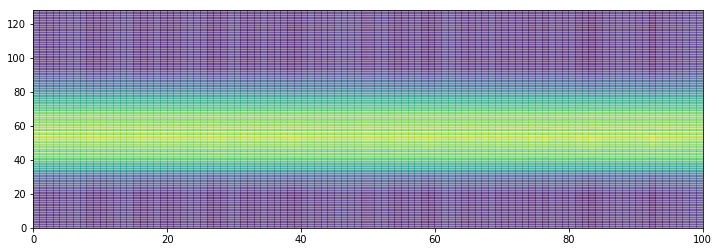

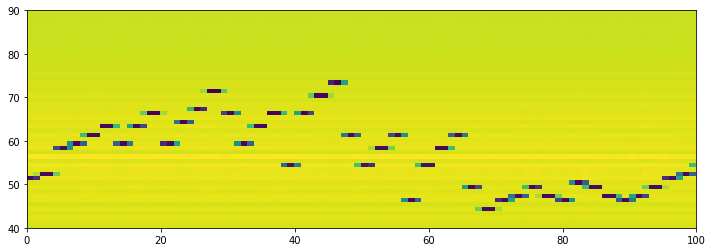

Train on 40000 samples, validate on 10000 samples

Epoch 1/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.8349 - acc: 0.0344
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.03890, saving model to Models/sgd_t22_lr_0Dot01-momentum_0Dot05-decay_0Dot0-01-0.04.hdf5
40000/40000 [==============================] - 12s 297us/step - loss: 14.8350 - acc: 0.0343 - val_loss: 14.9050 - val_acc: 0.0389

Epoch 2/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.8354 - acc: 0.0330
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc did not improve
40000/40000 [==============================] - 10s 253us/step - loss: 14.8351 - acc: 0.0330 - val_loss: 14.9078 - val_acc: 0.0283

Epoch 3/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.8329 - acc: 0.0322
Epoch 00003: saving model to Models/tst-best_only.hdf5
Epoch 00003: val_acc did not improve
40000/40000 [================

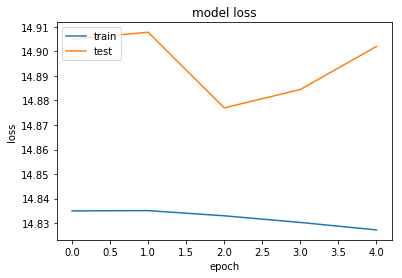

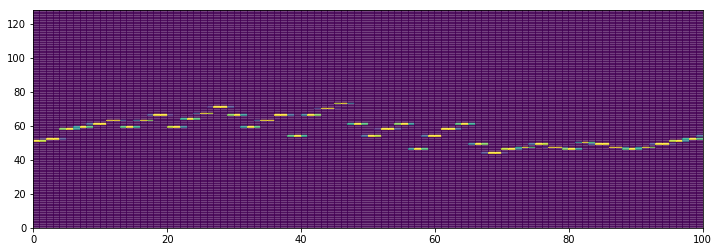

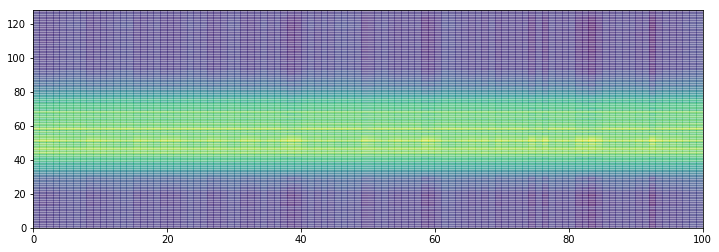

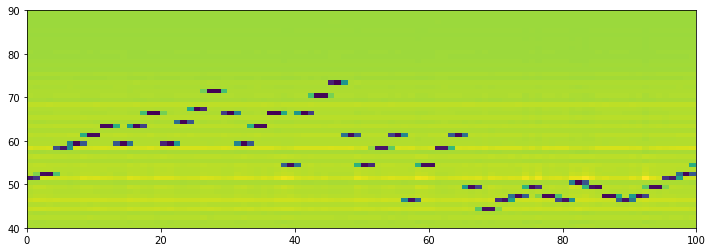

Train on 40000 samples, validate on 10000 samples

Epoch 1/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.8411 - acc: 0.0345
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.02680, saving model to Models/sgd_t22_lr_0Dot01-momentum_0Dot05-decay_0Dot0-01-0.03.hdf5
40000/40000 [==============================] - 12s 294us/step - loss: 14.8407 - acc: 0.0345 - val_loss: 14.8328 - val_acc: 0.0268

Epoch 2/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.8350 - acc: 0.0334
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.02680 to 0.03000, saving model to Models/sgd_t22_lr_0Dot01-momentum_0Dot05-decay_0Dot0-02-0.03.hdf5
40000/40000 [==============================] - 10s 249us/step - loss: 14.8346 - acc: 0.0334 - val_loss: 14.8342 - val_acc: 0.0300

Epoch 3/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.8017 - acc: 0.0354
Epoch 00003: saving m

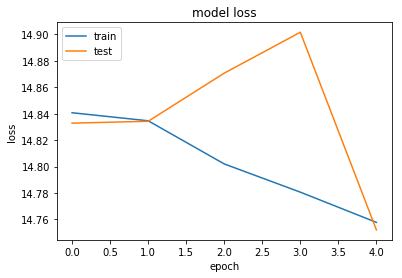

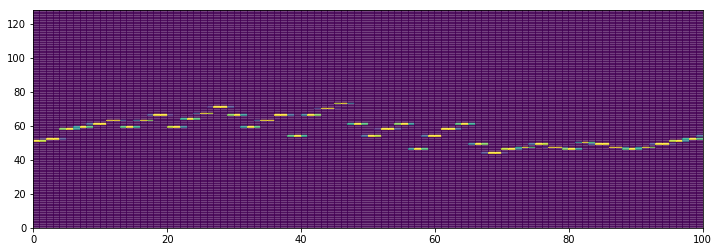

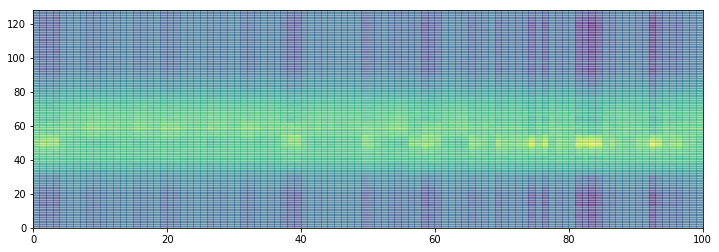

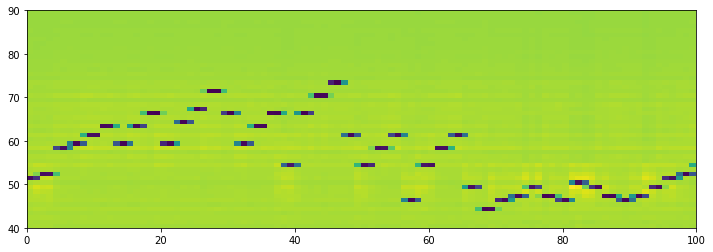

Train on 40000 samples, validate on 10000 samples

Epoch 1/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.7285 - acc: 0.0450
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.04250, saving model to Models/sgd_t22_lr_0Dot01-momentum_0Dot05-decay_0Dot0-01-0.04.hdf5
40000/40000 [==============================] - 12s 295us/step - loss: 14.7283 - acc: 0.0450 - val_loss: 14.7734 - val_acc: 0.0425

Epoch 2/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.7061 - acc: 0.0491
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.04250 to 0.04620, saving model to Models/sgd_t22_lr_0Dot01-momentum_0Dot05-decay_0Dot0-02-0.05.hdf5
40000/40000 [==============================] - 10s 251us/step - loss: 14.7058 - acc: 0.0491 - val_loss: 14.7976 - val_acc: 0.0462

Epoch 3/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.6529 - acc: 0.0569
Epoch 00003: saving m

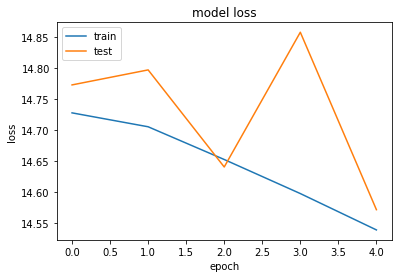

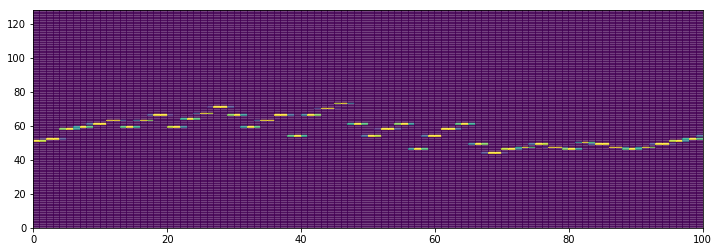

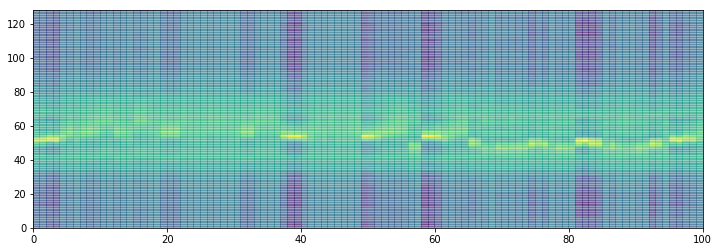

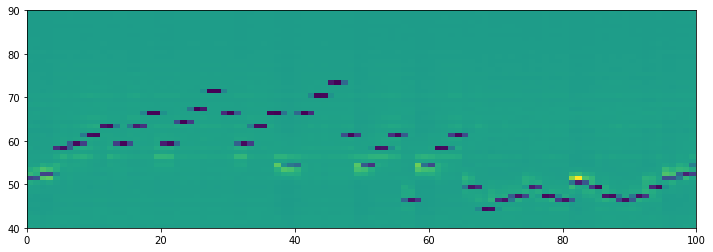

Train on 40000 samples, validate on 10000 samples

Epoch 1/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.4348 - acc: 0.0872
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.09050, saving model to Models/sgd_t22_lr_0Dot01-momentum_0Dot05-decay_0Dot0-01-0.09.hdf5
40000/40000 [==============================] - 12s 299us/step - loss: 14.4359 - acc: 0.0872 - val_loss: 14.4397 - val_acc: 0.0905

Epoch 2/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.3424 - acc: 0.0944
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.09050 to 0.10040, saving model to Models/sgd_t22_lr_0Dot01-momentum_0Dot05-decay_0Dot0-02-0.10.hdf5
40000/40000 [==============================] - 10s 247us/step - loss: 14.3411 - acc: 0.0944 - val_loss: 14.3056 - val_acc: 0.1004

Epoch 3/5
39936/40000 [============================>.] - ETA: 0s - loss: 14.2303 - acc: 0.1045
Epoch 00003: saving m

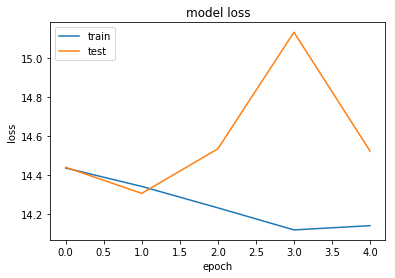

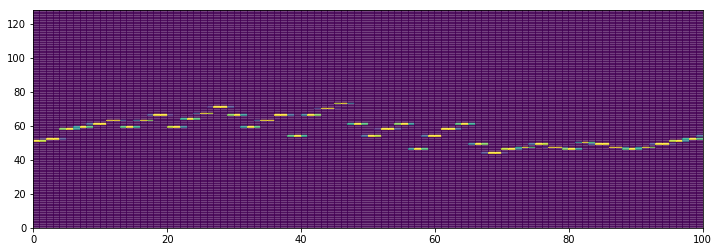

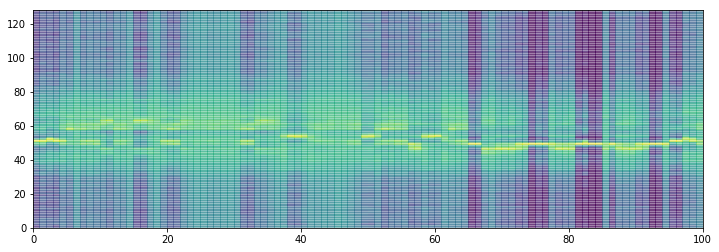

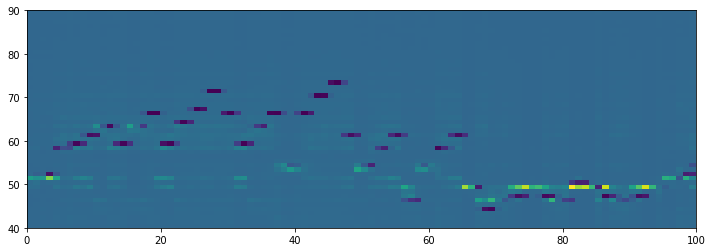

In [35]:
opt_par = {'lr': 0.01, 'momentum': 0.05,'decay':0.000}
# for Xs,Ys in cDATA:
Xs,Ys = cDATA
if 1:
    compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)
#     compare(log = 1, mode = 'test',chroma = 0)
    plt.show()

    for i in range(5):
        agent,r = pretrain(agent,
#                            batchsize=-1,
                            batchsize = 50000,
#                             batchsize = 100000,
                           nepc = 5)
        compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)
#     compare(log = 1, mode = 'test',chroma = 0)
        plt.show()

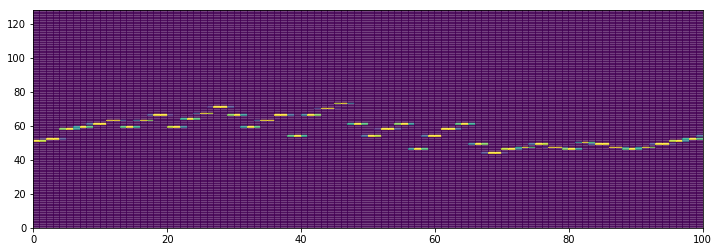

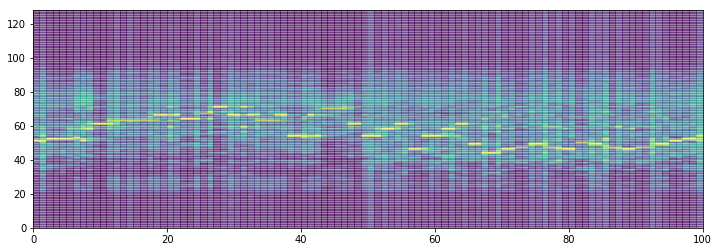

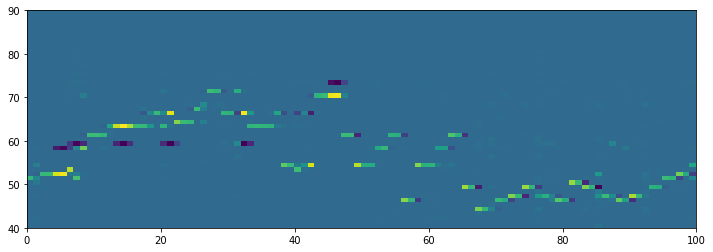

Train on 338890 samples, validate on 84723 samples

Epoch 1/10
338432/338890 [============================>.] - ETA: 0s - loss: 6.9625 - acc: 0.4076
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.41439, saving model to Models/sgd_t22_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.41.hdf5
338890/338890 [==============================] - 79s 234us/step - loss: 6.9624 - acc: 0.4076 - val_loss: 6.9318 - val_acc: 0.4144

Epoch 2/10
338432/338890 [============================>.] - ETA: 0s - loss: 6.7753 - acc: 0.4123
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.41439 to 0.42033, saving model to Models/sgd_t22_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.42.hdf5
338890/338890 [==============================] - 81s 238us/step - loss: 6.7754 - acc: 0.4123 - val_loss: 6.8500 - val_acc: 0.4203

Epoch 3/10
338432/338890 [============================>.] - ETA: 0s - loss: 6.6929 - acc: 0.4152
Epoch 00003: s

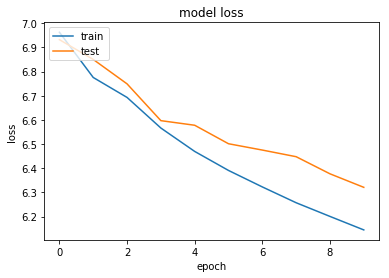

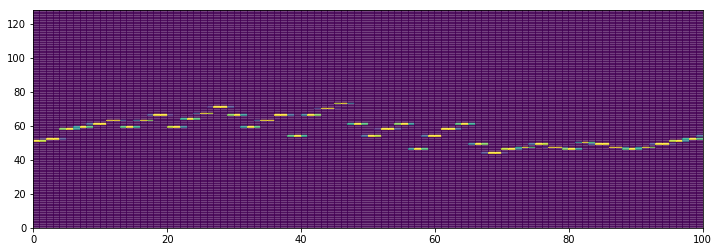

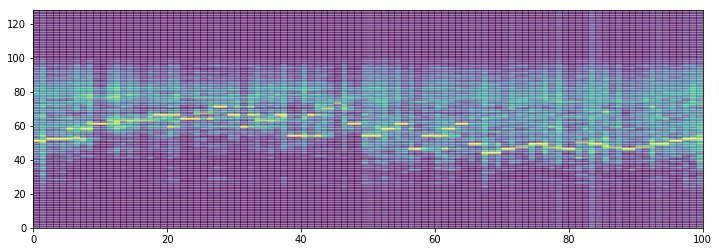

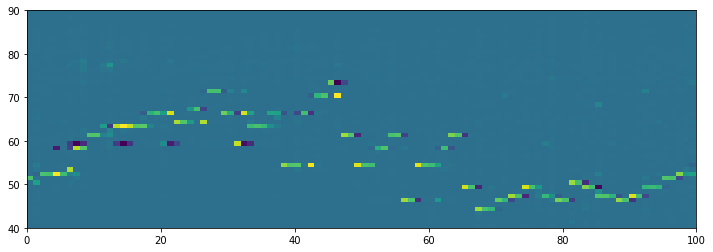

In [24]:
opt_par = {'lr': 0.01, 'momentum': 0.75,'decay':0.000}
# for Xs,Ys in cDATA:
Xs,Ys = cDATA
if 1:
    compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)
#     compare(log = 1, mode = 'test',chroma = 0)
    plt.show()

    for i in range(1):
        agent,r = pretrain(agent,
                           batchsize=-1,
#                             batchsize = 50000,
#                             batchsize = 100000,
                           nepc = 10)
    compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)
#     compare(log = 1, mode = 'test',chroma = 0)
    plt.show()

sample/MIDI/jsbach/jsbwv533P-2S60


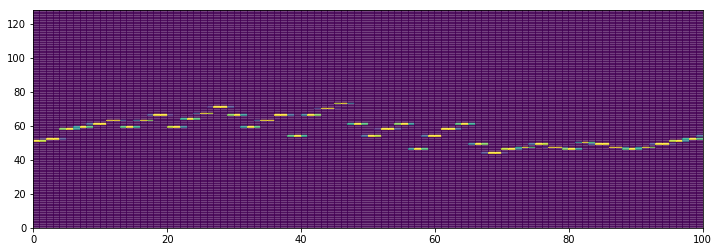

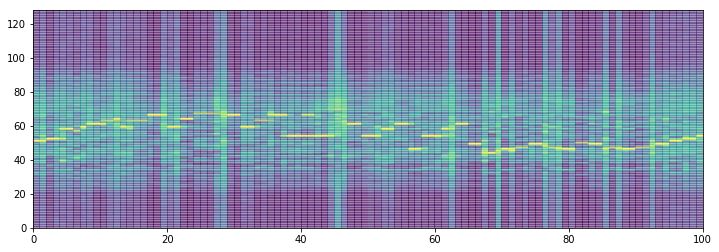

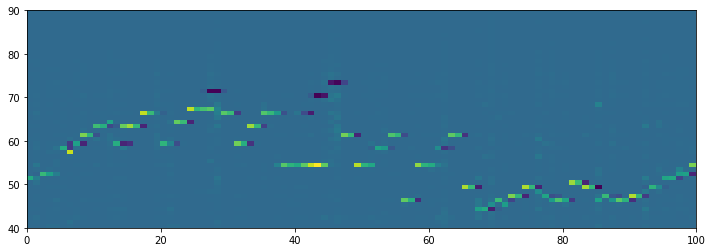

In [7]:
print data[0]['name']
compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)

In [ ]:
agent = _

In [11]:
def to_chunk(self,new_rate):
    ratio = self.bitrate/new_rate
    idx = np.arange(0, len(self.ts) ,ratio).astype(int)
    print len(idx)
    return np.array(np.split(self.xs, idx[1:])[:-1])

def transcribe(signal, agent,norm = 1, chroma = 1, log = 1):
    if isinstance( signal, util.piece):
        signal.downsample(16000)
        signal = signal.to_chunk(20)
#     plt.figure()

#     assert not (pXs[0] - Xs[0]).any()
#     pXs = Xs[:500]
#     pYs_exp = Ys[:500]
    pYs_act = agent.model.predict_on_batch(signal) 
    pYs_act += 1E-5
#     compare(log = 1)
    if chroma:
#        pYs_exp = mroll2chroma(pYs_exp)
        pYs_act = mroll2chroma(pYs_act,norm = 1)        
    Z1 = pYs_act.T
    if log:
        plt.pcolormesh(Z1,
                       alpha = 1.0,
                  norm=matplotlib.colors.LogNorm(vmin=Z1.min(), vmax=Z1.max())
                  )
    else:
        plt.pcolormesh(Z1)
    fs = np.arange(pYs_act.shape[-1])[None,:]
    pYs_act = (pYs_act)*fs
    ipd.display(ipd.Audio(midi_roll_play(pYs_act),rate = 16000))
    return pYs_act
import librosa
import librosa.display
def cqt(p):
    sr = p.bitrate
    y  = p.xs
    chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr, 
#                                            window = 50,
#                                           hop_length = 1
                                          )
    librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
    plt.show()
    return chroma_cq.T
def stft(p):
    sr = p.bitrate
    y  = p.xs
    chroma_cq = librosa.feature.chroma_stft(y=y, sr=sr,
                                           n_chroma=12, n_fft=800,
                                           hop_length=800)
    librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
    plt.show()
    return chroma_cq.T
# cqt(p)
# stft(p)
# compare(log = 0)

In [ ]:
# 'C','C#'
import librosa


9252
160


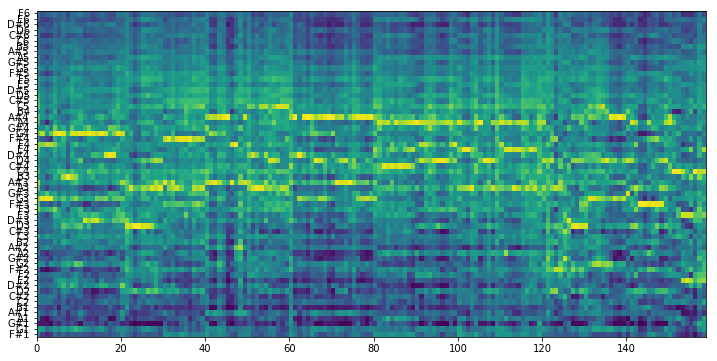

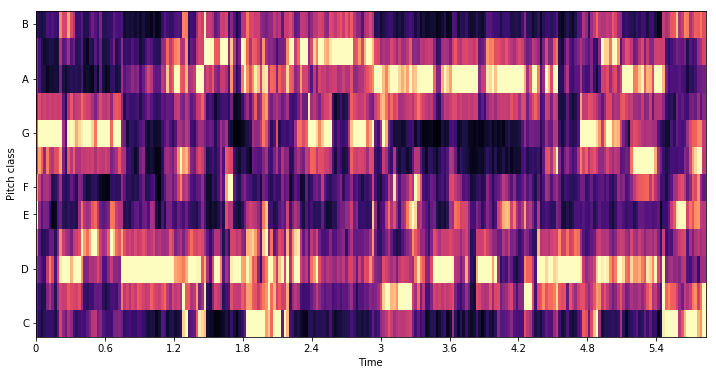

array([[ 0.29838511,  0.30968693,  0.45948013, ...,  0.40782618,
         0.41294504,  0.1969391 ],
       [ 0.19326891,  0.21070745,  0.33723603, ...,  0.25828944,
         0.26243665,  0.16410209],
       [ 0.11930576,  0.14642308,  0.24632334, ...,  0.1516938 ,
         0.15725309,  0.1337786 ],
       ..., 
       [ 0.85325104,  0.57288205,  0.19548991, ...,  0.33261963,
         0.45495649,  0.65502129],
       [ 0.77856077,  0.71348253,  0.44774659, ...,  0.34028014,
         0.47453645,  0.72107658],
       [ 1.        ,  0.98160587,  0.46005766, ...,  0.3534218 ,
         0.59011213,  0.62565814]])

In [22]:
import util#
best_agent = agent
# wavfile = 'sample/waltz_for_toutzy.wav'
# wavfile = 'sample/waltz_for_toutzy_50.wav'
# wavfile = 'sample/Tamacun.wav'
wavfile = 'sample/MIDI/composer-bach-edition-bg-genre-cant-work-0002-format-midi1-multi-zip-number-01.wav'
p = util.piece(wavfile)
print p.x0.max()
if p.x0.dtype=='int16':
    p.x0 = p.x0.astype('float32')
    p.x0 = p.x0/2**15
p.xs = p.x0
# p.xs = p.xs.astype('float32')
p.downsample(16000)
# p.bitrate = 18000
p.trimto(18,26)
# p.trimto(60,100)
# p.trimto(100,140)
# print len(p.xs)
chunks = to_chunk(p,20)[:]
chunks = np.array(chunks)
# chunks = util_midi.norm_by_rmsq(chunks,norm = 1)

eps = 1E-8
# chunks_SD = chunks.std(axis = 1,keepdims= 1) + eps
# chunks_M = chunks.mean(axis = 1,keepdims= 1) 
# # NZidx = np.squeeze( (chunks_SD)/chunks_M > 8)
# # chunks = chunks[NZidx,:]; mroll=mroll[NZidx,:]            
# # chunks = (chunks - chunks_M[NZidx,:])/chunks_SD[NZidx,:]
# chunks = (chunks - chunks_M)/chunks_SD
# chunks.shape
# len(p.x0)
# print len(chunks)
plt.figure(figsize = [12,6])
mroll = transcribe(chunks,best_agent,chroma = 0,)
ytk = librosa.midi_to_note(range(0,128))
plt.yticks(np.arange(0,128) +.5,librosa.midi_to_note(range(0,128)))
plt.ylim(30,90)

ipd.display(ipd.Audio(p.xs,rate=16000))
plt.figure(figsize = [12,6])
# print p.xs.dtype
cqt(p)


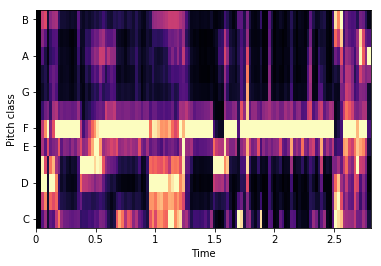

In [59]:
ipd.Audio(midi_roll_play(stft(p)),rate=16000)

In [149]:
%%bash
cd sample
wget "https://www.audioblocks.com/join/register?pre_email_click=details"
# !pip install librosa --user 


--2017-12-09 20:48:43--  https://www.audioblocks.com/join/register?pre_email_click=details
Resolving www.audioblocks.com (www.audioblocks.com)... 52.203.100.91, 52.203.214.179
Connecting to www.audioblocks.com (www.audioblocks.com)|52.203.100.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘register?pre_email_click=details.1’

     0K .......... .......... .......... .......... ..........  260K
    50K ....                                                    160M=0.2s

2017-12-09 20:48:44 (282 KB/s) - ‘register?pre_email_click=details.1’ saved [55613]



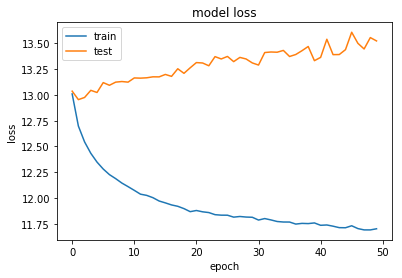

In [80]:
plot_model_loss(r)
# %matplotlib inline
# plt.plot(r.history['val_acc'])